# **Aprendizaje no supervisado**

## Clustering

### **Introducción - Clasificación _vs_ Clustering**

En el campo del aprendizaje automático, clasificación y clustering son técnicas cruciales para analizar datos, pero sirven a propósitos distintos.

***Clasificación***

La clasificación es un método de aprendizaje supervisado que predice la etiqueta de nuevas instancias basándose en un conjunto de entrenamiento con etiquetas conocidas. Se utiliza para tareas como detectar correos no deseados o diagnosticar enfermedades, evaluándose por su precisión y capacidad de generalización.

***Clustering***

El clustering, en cambio, es un método de aprendizaje no supervisado que agrupa objetos según su similitud sin etiquetas predefinidas. Es útil para descubrir estructuras en los datos y segmentar mercados, entre otros aplicaciones.

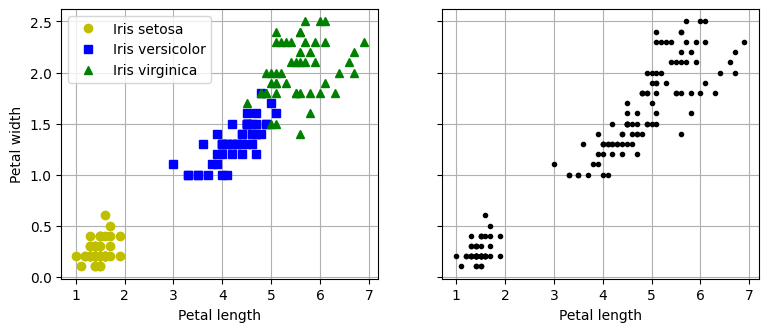

In [1]:

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

**Nota**: la siguiente celda muestra cómo un modelo de mezcla gaussiana (explicado más adelante en este notebook) puede realmente separar estos grupos bastante bien utilizando las 4 características: longitud y anchura de los pétalos, y longitud y anchura de los sépalos. Este código asigna cada elemento a una clase. En lugar de codificar el mapeo, el código elige la clase más común para cada cluster usando la función `scipy.stats.mode()`:

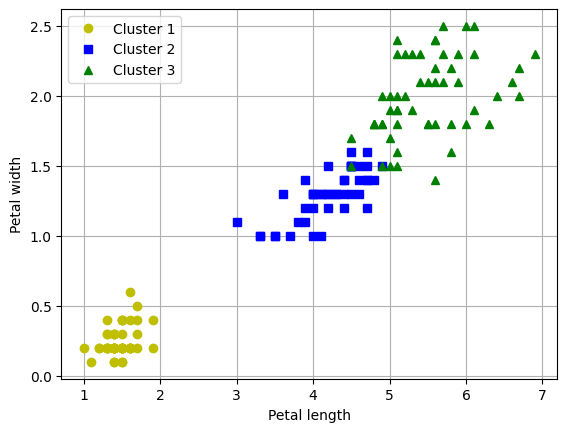

In [2]:
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode] = class_id

y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.grid()
plt.show()

¿Cuál es la proporción de plantas de iris que asignamos al grupo correcto?

In [3]:
(y_pred==y).sum() / len(y_pred)

np.float64(0.9666666666666667)

## K-Means

El algoritmo K-Means es uno de los métodos de clustering más utilizados en el aprendizaje no supervisado. Su objetivo es dividir un conjunto de datos en 𝐾 grupos (o clusters) distintos basándose en la similitud de las características de los datos.

**Fit y predict**

Vamos a entrenar un agrupador K-Means en un conjunto de datos de manchas. Intentará encontrar el centro de cada mancha y asignar cada instancia a la mancha más cercana:

In [4]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Ahora vamos a trazarlos:

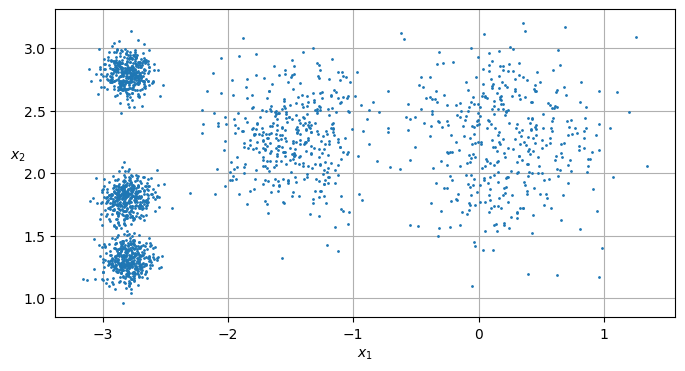

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

Cada instancia se asignó a uno de los 5 clusters:

In [6]:
y_pred

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

In [7]:
y_pred is kmeans.labels_

True

Y se estimaron los siguientes 5 _centroides_ (es decir, centros de conglomerados):

In [8]:
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

Ten en cuenta que la instancia `KMeans` conserva las etiquetas de las instancias con las que fue entrenada. De forma algo confusa, en este contexto, la _etiqueta_ de una instancia es el índice del cluster al que se asigna esa instancia (no son target, son predicciones):

In [9]:
kmeans.labels_

array([0, 0, 4, ..., 3, 1, 0], dtype=int32)

Por supuesto, podemos predecir las etiquetas de las nuevas instancias:

In [10]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

**Límites de la decisión**

Vamos a trazar los límites de decisión del modelo. Esto nos da un _diagrama de Voronoi_:

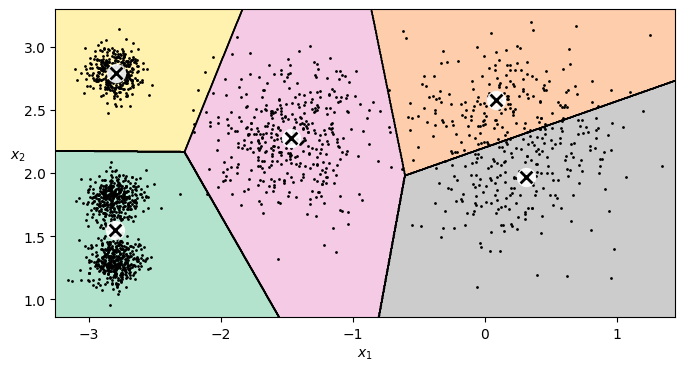

In [14]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

No está mal. Algunas de las instancias cercanas a los bordes probablemente se asignaron al clúster equivocado, pero en general se ve bastante bien.

**Hard Clustering _vs_ Soft Clustering**

### Hard Clustering
El Hard Clustering asigna cada punto de datos a un único cluster, sin ambigüedad. Cada punto pertenece a un solo grupo, lo que significa que la pertenencia es exclusiva.

Características:
- Exclusividad: Cada punto es asignado a un solo cluster.
- Determinístico: La asignación no admite incertidumbre; un punto o pertenece completamente a un cluster o no pertenece en absoluto.
- Ejemplos comunes: K-Means y Hierarchical Clustering son técnicas típicas de hard clustering.

Este enfoque es adecuado para aplicaciones donde las categorías son mutuamente excluyentes y bien definidas, como en la clasificación de documentos en categorías específicas donde cada documento solo puede pertenecer a un tema.

### Soft Clustering
En contraste, el Soft Clustering permite que cada punto de datos tenga un grado de pertenencia en múltiples clusters. No se trata simplemente de decidir si un punto pertenece a un grupo o no, sino más bien de evaluar el grado de pertenencia o probabilidad de que el punto esté en varios grupos simultáneamente.

Características:
- Probabilístico: Los puntos pueden pertenecer a múltiples clusters con diferentes grados de probabilidad o membresía.
- Flexible: Ideal para datos donde las categorías no son mutuamente excluyentes o las relaciones son más complejas.
- Ejemplos comunes: Gaussian Mixture Models (GMM) y Fuzzy C-Means son ejemplos de técnicas de soft clustering.

Soft clustering es útil en escenarios donde los datos pueden exhibir múltiples categorías simultáneamente, como en la asignación de géneros a películas, donde una película puede ser tanto comedia como drama.

En lugar de elegir arbitrariamente el cluster más cercano para cada instancia, lo que se llama _hard clustering_, sería mejor medir la distancia de cada instancia a los 5 centroides. Esto es lo que hace el método `transform()`:

In [12]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

Puede comprobar que se trata efectivamente de la distancia euclidiana entre cada instancia y cada centroide:

In [13]:

np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

### The K-Means Algorithm

El algoritmo K-Means es uno de los algoritmos de agrupación más rápidos, y también uno de los más sencillos:
* Primero se inicializan $k$ centroides al azar: por ejemplo, se eligen $k$ instancias distintas al azar del conjunto de datos y se colocan los centroides en sus ubicaciones.
* Se repite hasta la convergencia (es decir, hasta que los centroides dejan de moverse):
    * Asignar cada instancia al centroide más cercano.
    * Actualizar los centroides para que sean la media de las instancias que se les han asignado.

La clase `KMeans` utiliza por defecto una técnica de inicialización optimizada. Para obtener el algoritmo original de K-Means (sólo con fines educativos), debe establecer `init="random"` y `n_init=1`.

Vamos a ejecutar el algoritmo K-Means durante 1, 2 y 3 iteraciones, para ver cómo se mueven los centroides:

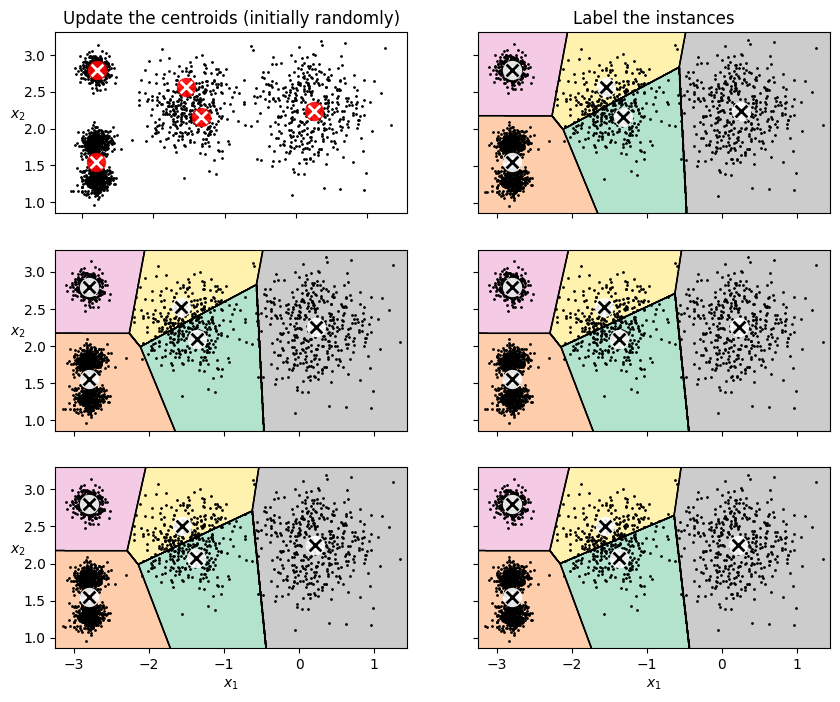

In [15]:

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

**Variabilidad K-Means**

En el algoritmo original de K-Means, los centroides se inicializan aleatoriamente y el algoritmo simplemente ejecuta una única iteración para mejorar gradualmente los centroides, como vimos anteriormente.

Sin embargo, uno de los principales problemas de este enfoque es que si se ejecuta K-Means varias veces (o con diferentes semillas aleatorias), puede converger a soluciones muy diferentes, como se puede ver a continuación:

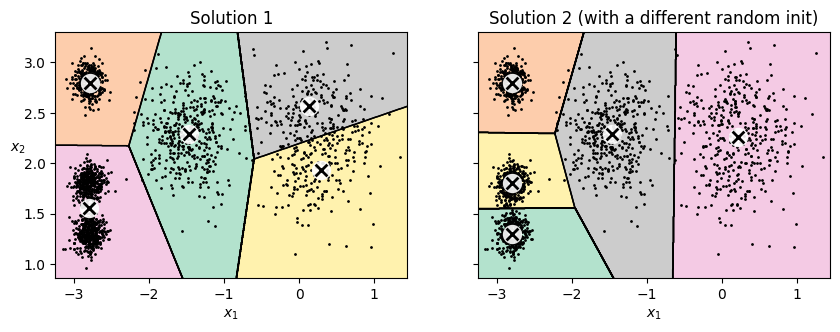

In [16]:

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

plt.show()

In [17]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

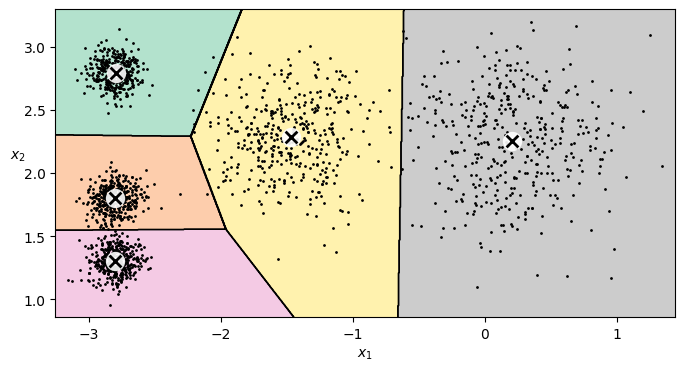

In [18]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Inercia

Para seleccionar el mejor modelo, necesitaremos una forma de evaluar el rendimiento de un modelo K-Mean. Por desgracia, la agrupación es una tarea no supervisada, por lo que no disponemos de los objetivos. Pero al menos podemos medir la distancia entre cada instancia y su centroide. Esta es la idea que hay detrás de la métrica _inertia_:

In [19]:
kmeans.inertia_

211.5985372581684

In [20]:
kmeans_rnd_init1.inertia_  

219.58201503602282

In [21]:
kmeans_rnd_init2.inertia_  

211.5985372581684

Como se puede comprobar fácilmente, la inercia es la suma de las distancias al cuadrado entre cada instancia de entrenamiento y su centroide más cercano:

In [22]:
X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

np.float64(211.59853725816868)

El método `score()` devuelve la inercia negativa. ¿Por qué negativa? Pues porque el método `score()` de un predictor debe respetar siempre la regla "_mayor es mejor_".

In [23]:
kmeans.score(X)

-211.59853725816836

### Inicializaciones múltiples

Por tanto, una forma de resolver el problema de la variabilidad es ejecutar el algoritmo K-Means varias veces con distintas inicializaciones aleatorias y seleccionar la solución que minimice la inercia.

In [24]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

Como se puede ver, terminamos con el modelo inicial, que es sin duda la solución óptima de K-Means (al menos en términos de inercia, y suponiendo $k=5$).

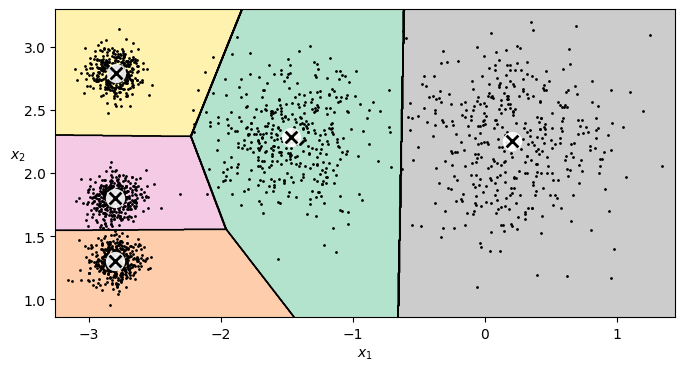

In [25]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [26]:
kmeans_rnd_10_inits.inertia_

211.5985372581684

agv_ nos da un valor igual, con lo que no hemos mejorado el modelo. 

### Métodos de inicialización de centroides

En lugar de inicializar los centroides de forma totalmente aleatoria, es preferible inicializarlos utilizando el siguiente algoritmo, propuesto en un [documento de 2006](https://goo.gl/eNUPw6) por David Arthur y Sergei Vassilvitskii:
* Tomar un centroide $c_1$, elegido uniformemente al azar del conjunto de datos.
* Tomar un nuevo centroide $c_i$, eligiendo una instancia $\mathbf{x}_i$ con probabilidad $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ donde $D(\mathbf{x}_i)$ es la distancia entre la instancia $\mathbf{x}_i$ y el centroide más cercano ya elegido. Esta distribución de probabilidad asegura que las instancias que están más lejos de los centroides ya elegidos tienen muchas más probabilidades de ser seleccionadas como centroides.
* Repita el paso anterior hasta que se hayan elegido todos los $k$ centroides.

El resto del algoritmo K-Means++ es K-Means normal. Con esta inicialización, es mucho menos probable que el algoritmo K-Means converja a una solución subóptima, por lo que es posible reducir `n_init` considerablemente. La mayoría de las veces, esto compensa en gran medida la complejidad adicional del proceso de inicialización.

### K-Means acelerado

El algoritmo K-Means puede acelerarse a veces evitando muchos cálculos de distancia innecesarios: esto se consigue explotando la desigualdad del triángulo (dados tres puntos A, B y C, la distancia AC es siempre tal que AC ≤ AB + BC) y llevando la cuenta de los límites inferior y superior de las distancias entre instancias y centroides (para más detalles, véase este [artículo de 2003](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) de Charles Elkan).

### Mini-Batch K-Means

Scikit-Learn también implementa una variante del algoritmo K-Means que admite minilotes (véase [este documento](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [27]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)

In [28]:
minibatch_kmeans.inertia_

211.6589937457431

Primero carguemos MNIST:

In [29]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")

Vamos a dividir el conjunto de datos:

In [30]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

A continuación, vamos a escribir el conjunto de entrenamiento en un `memmap`:

In [31]:
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                     shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush()

In [32]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                   n_init=3, random_state=42)
minibatch_kmeans.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, n_init=3, random_state=42)

Vamos a trazar la relación de inercia y la relación de tiempo de entrenamiento entre Mini-batch K-Means y K-Means normal:

In [ ]:

from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

plt.show()

### Encontrar el número óptimo de conglomerados

¿Y si el número de clusters se fija en un valor inferior o superior a 5?

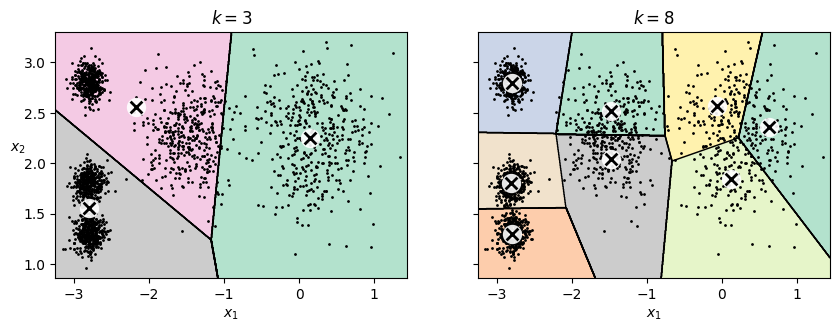

In [33]:

kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

Estos dos modelos no se ven muy bien. ¿Y sus inercias?

In [34]:
kmeans_k3.inertia_

653.216719002155

In [35]:
kmeans_k8.inertia_

119.22484592677111

No, no podemos tomar simplemente el valor de $k$ que minimiza la inercia, ya que ésta sigue disminuyendo a medida que aumentamos $k$. De hecho, cuantos más conglomerados haya, más cerca estará cada instancia de su centroide más cercano y, por tanto, menor será la inercia. Sin embargo, podemos representar la inercia en función de $k$ y analizar la curva resultante:

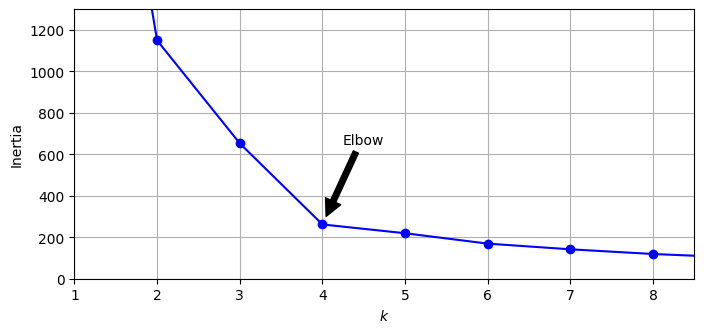

In [36]:

kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

Como se puede ver, hay un codo en $k=4$, lo que significa que menos agrupaciones que ésa serían malas, y más agrupaciones no ayudarían mucho y podrían reducir las agrupaciones a la mitad. Así que $k=4$ es una buena elección. Por supuesto, en este ejemplo no es perfecto, ya que significa que las dos manchas de la parte inferior izquierda se considerarán como un solo conglomerado, pero no deja de ser una agrupación bastante buena.

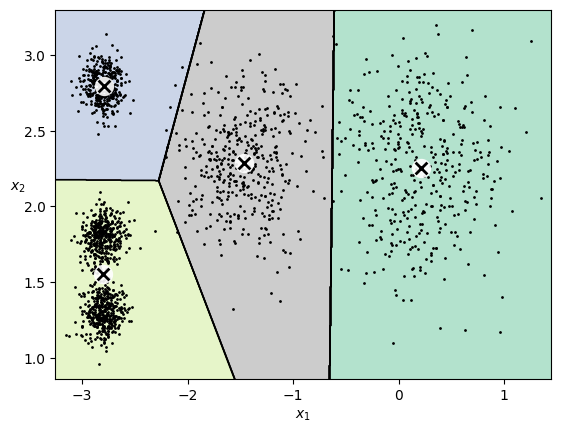

In [37]:
plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

Otro método consiste en considerar la _puntuación de silueta_, que es el _coeficiente de silueta_ medio de todas las instancias. El coeficiente de silueta de una instancia es igual a (_b_ - _a_) / max(_a_, _b_), donde _a_ es la distancia media a las demás instancias del mismo clúster (es la _distancia media intraclúster_), y _b_ es la _distancia media al clúster más cercano_, es decir, la distancia media a las instancias del clúster más cercano (definido como el que minimiza _b_, excluyendo el clúster de la propia instancia). El coeficiente de silueta puede variar entre -1 y +1: un coeficiente cercano a +1 significa que la instancia está bien dentro de su propio cluster y lejos de otros clusters, mientras que un coeficiente cercano a 0 significa que está cerca del límite de un cluster, y finalmente un coeficiente cercano a -1 significa que la instancia puede haber sido asignada al cluster equivocado.

Vamos a trazar la puntuación de la silueta en función de $k$:

In [38]:
from sklearn.metrics import silhouette_score

In [39]:
silhouette_score(X, kmeans.labels_)

np.float64(0.655517642572828)

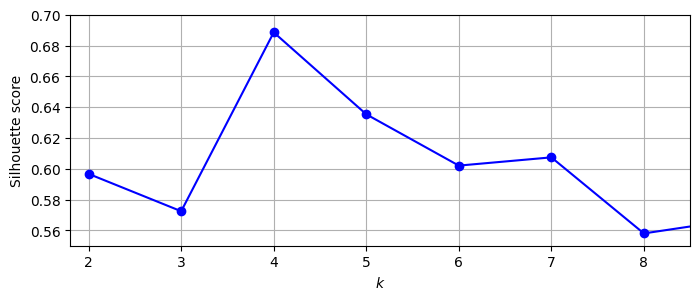

In [40]:

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
plt.show()

Como puede ver, esta visualización es mucho más mejor que la anterior: en particular, aunque confirma que $k=4$ es una muy buena elección, también subraya el hecho de que $k=5$ es bastante buena también.

El coeficiente de silueta de cada instancia, ordenado por el cluster al que está asignado y por el valor del coeficiente, ofrece una visualización aún más informativa. Esto se denomina _diagrama de siluetas_:

In [ ]:

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

Como puede ver, $k=5$ parece la mejor opción aquí, ya que todos los conglomerados tienen aproximadamente el mismo tamaño, y todos cruzan la línea discontinua, que representa la puntuación media de la silueta.

## Límites de K-Means

Generemos un conjunto de datos más difícil, con manchas alargadas y densidades variables, y demostremos que K-Means tiene dificultades para agruparlo correctamente:

In [ ]:

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")

plt.show()

## Uso de la agrupación para la segmentación de imágenes

Descarga la imagen de la mariquita:

In [ ]:
import urllib.request
from pathlib import Path

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
directory = Path('img')
filepath = directory / filename

if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    directory.mkdir(parents=True, exist_ok=True)  # Asegura que el directorio existe
    urllib.request.urlretrieve(url, filepath)

In [ ]:
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

In [45]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [ ]:

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

## Uso de la agrupación para el aprendizaje semisupervisado

Otro caso de uso de la agrupación es el aprendizaje semisupervisado, cuando tenemos muchas instancias sin etiquetar y muy pocas etiquetadas.

Vamos a abordar el conjunto de datos _digits_, que es un conjunto de datos sencillo similar al MNIST que contiene 1.797 imágenes de 8×8 en escala de grises que representan los dígitos del 0 al 9.

In [47]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Veamos el rendimiento de un modelo de regresión logística cuando sólo tenemos 50 instancias etiquetadas:

In [ ]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

In [ ]:
log_reg.score(X_test, y_test)

In [ ]:
# medir la precisión cuando utilizamos todo el conjunto de entrenamiento
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

Es mucho menos que antes, por supuesto. Veamos cómo podemos hacerlo mejor. En primer lugar, agrupemos el conjunto de entrenamiento en 50 clusters y, a continuación, busquemos en cada cluster la imagen más cercana al centroide. A estas imágenes las llamaremos imágenes representativas:

In [51]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

Ahora vamos a trazar estas imágenes representativas y a etiquetarlas manualmente:

In [ ]:

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

In [53]:
y_representative_digits = np.array([
    1, 3, 6, 0, 7, 9, 2, 4, 8, 9,
    5, 4, 7, 1, 2, 6, 1, 2, 5, 1,
    4, 1, 3, 3, 8, 8, 2, 5, 6, 9,
    1, 4, 0, 6, 8, 3, 4, 6, 7, 2,
    4, 1, 0, 7, 5, 1, 9, 9, 3, 7
])

Ahora tenemos un conjunto de datos con sólo 50 instancias etiquetadas, pero en lugar de ser instancias completamente aleatorias, cada una de ellas es una imagen representativa de su clúster. Veamos si el rendimiento es mejor:

In [ ]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

Vaya. Hemos pasado de una precisión del 74,8% al 84,9%, aunque todavía sólo estamos entrenando el modelo con 50 instancias. Dado que a menudo es costoso y doloroso etiquetar instancias, especialmente cuando lo tienen que hacer manualmente expertos, es una buena idea hacer que etiqueten instancias representativas en lugar de instancias aleatorias.

Pero quizá podamos ir un paso más allá: ¿y si propagamos las etiquetas a todas las demás instancias del mismo clúster?

In [55]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [ ]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

In [ ]:
log_reg.score(X_test, y_test)

Hemos obtenido otro aumento significativo de la precisión. Veamos si podemos hacerlo aún mejor ignorando el 1% de instancias que están más lejos del centro de su clúster: esto debería eliminar algunos valores atípicos:

In [58]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

Vaya, ¡otro aumento de la precisión! Incluso hemos superado ligeramente el rendimiento que obtuvimos entrenando con el conjunto de entrenamiento totalmente etiquetado.

Nuestras etiquetas propagadas son bastante buenas: su precisión ronda el 97,6%:

In [ ]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

Ahora podrías hacer algunas iteraciones de *aprendizaje activo*:
1. Etiquetar manualmente las instancias de las que el clasificador está menos seguro, si es posible, agrupándolas en clusters distintos.
2. Entrenar un nuevo modelo con estas etiquetas adicionales.